In [19]:
import torch
import numpy as np
import datasets
import os
#import umap
import sys
import evaluate
import seaborn as sns
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Transformer, Pooling
from nltk import sent_tokenize
from IPython.core.debugger import Pdb, set_trace
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import util
#from tqdm.notebook import tqdm
from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view

datasets.disable_caching()

cache_dir = '/data/john/cache'

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Datasets, Standardize Column Names, and Aggregate

In [2]:
allsides_dir = '/data/john/projects/llm_eval/data/all_sides/test.json'
ppp_dir = '/data/john/projects/llm_eval/data/privacy_policy/3p_data.csv'

ds = DatasetDict({
    'allsides': Dataset.from_json(allsides_dir),
    'ppp': Dataset.from_csv(ppp_dir),
})

cols = {
    'allsides': ['Left',
                 'Right',
                 'Ahmed_Intersection',
                 'Naman_Intersection',
                 'Helen_Intersection',
                 'AllSides_Intersection',],
    'ppp': ['Company_1',
            'Company_2',
            'Annotator1',
            'Annotator2',
            'Annotator3']
}

col_maps = {
    'allsides': {'Left': 'd1',
                 'Right': 'd2',
                 'Ahmed_Intersection': 'ref0',
                 'Naman_Intersection': 'ref1',
                 'Helen_Intersection': 'ref2',
                 'AllSides_Intersection': 'ref3'},
    'ppp': {'Company_1': 'd1',
            'Company_2': 'd2',
            'Annotator1': 'ref0',
            'Annotator2': 'ref1',
            'Annotator3': 'ref2'}
}

# remove extraneous columns
keep_cols = set(col_maps['allsides'].values())
for ds_key, ds_val in ds.items():
    ds[ds_key] = ds_val.remove_columns(set(ds_val.features.keys()) - set(cols[ds_key]))


# standardize column names
for ds_key, ds_val in ds.items():
    for old_name, new_name in col_maps[ds_key].items():
        ds_val = ds_val.rename_column(old_name, new_name)
    ds[ds_key] = ds_val

# add ds name as column to both datasets
for ds_key, ds_val in ds.items():
    ds[ds_key] = ds_val.add_column('name', [ds_key]*len(ds_val))

# concatenate datasets
ds['agg'] = datasets.concatenate_datasets(ds.values())

print(ds)

Generating train split: 137 examples [00:00, 1401.09 examples/s]
Generating train split: 135 examples [00:00, 2664.79 examples/s]


DatasetDict({
    allsides: Dataset({
        features: ['d1', 'd2', 'ref0', 'ref1', 'ref2', 'ref3', 'name'],
        num_rows: 137
    })
    ppp: Dataset({
        features: ['d1', 'd2', 'ref0', 'ref1', 'ref2', 'name'],
        num_rows: 135
    })
    agg: Dataset({
        features: ['d1', 'd2', 'ref0', 'ref1', 'ref2', 'ref3', 'name'],
        num_rows: 272
    })
})


# Set Sentence Transformer Models

In [3]:
sent_models = [
    'all-mpnet-base-v2',
    'multi-qa-mpnet-base-dot-v1',
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'multi-qa-distilbert-cos-v1',
    'all-MiniLM-L6-v2',
    'multi-qa-MiniLM-L6-cos-v1',
    'paraphrase-multilingual-mpnet-base-v2',
    'paraphrase-albert-small-v2',
    'paraphrase-multilingual-MiniLM-L12-v2',
    'paraphrase-MiniLM-L3-v2',
    'distiluse-base-multilingual-cased-v1',
    'distiluse-base-multilingual-cased-v2',
]

# Select Model and Plot Sentences

In [4]:
device='cuda:1'

def map_fn(sample, **fn_kwargs):
    cols = fn_kwargs['cols']
    model = fn_kwargs['model']
    for col in cols:
        sample[col + '-embeds'] = model.encode(sample[col])
        sample[col + '-sents'] = sent_tokenize(sample[col])
        sample[col + '-sent_lengths'] = len(sample[col + '-sents'])
        sample[col + '-sent_embeds'] = model.encode(sample[col + '-sents'], convert_to_numpy=True)
    return sample

data = {}
for model_name in sent_models:
    model = SentenceTransformer(sent_models[0], cache_folder='./cache')
    model = model.to(device)
    for key in ds.keys():
        data[model_name + '-' + key] = ds[key].map(
            map_fn, 
            fn_kwargs={'cols': cols[key],
                       'model': model},
        )

config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 711kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 41.8MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 310kB/s]
config.json: 100%|██████████| 571/571 [00:00<00:00, 3.66MB/s]
pytorch_model.bin:  91%|█████████ | 398M/438M [00:05<00:00, 69.1MB/s] 


KeyboardInterrupt: 

# Plot AllSides Vs. PPP

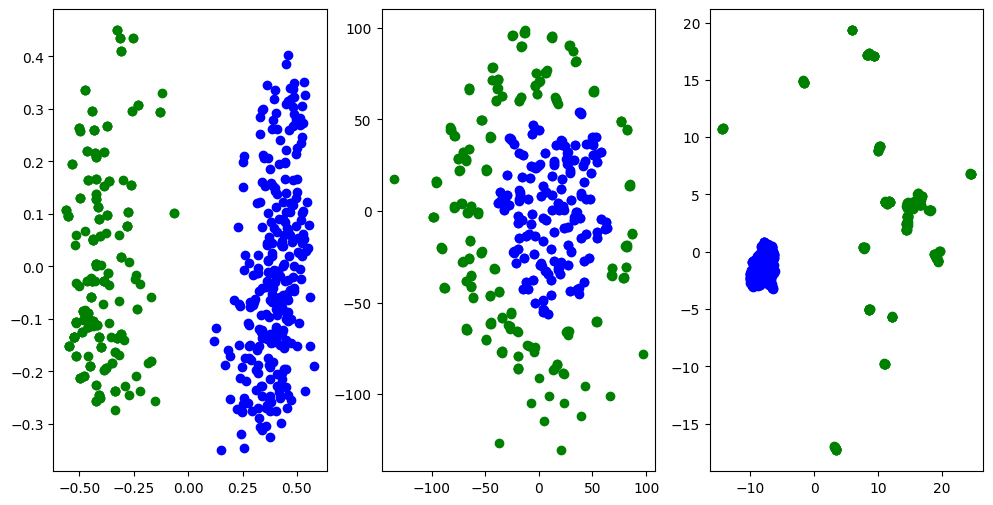

In [ ]:
model_name = 'all-mpnet-base-v2'
d1 = data[model_name + '-allsides'].with_format('numpy')
d2 = data[model_name + '-ppp'].with_format('numpy')
#cutoff = d['Left-embeds'].shape[0]

X1 = np.vstack((d1['Left-embeds'], d1['Right-embeds']))
X2 = np.vstack((d2['Company_1-embeds'], d2['Company_2-embeds']))
cutoff = X1.shape[0]

X = np.vstack((X1, X2))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_umap = umap.UMAP().fit_transform(X)

sample = 20
#X_pca[[0, sample]] = X_pca[[sample, 0]]
#X_pca[[1, sample+cutoff]] = X_pca[[sample+cutoff, 1]]
#print(X_pca[:2])
#plt.scatter(*X_pca[2:].T, color='green')
#plt.scatter(*X_pca[:2].T, color='blue')
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

# Plot PCA
ax[0].scatter(*X_pca[cutoff:].T, color='green')
ax[0].scatter(*X_pca[:cutoff].T, color='blue')

# Plot tSNE
ax[1].scatter(*X_tsne[cutoff:].T, color='green')
ax[1].scatter(*X_tsne[:cutoff].T, color='blue')

# Plot UMAP
ax[2].scatter(*X_umap[cutoff:].T, color='green')
ax[2].scatter(*X_umap[:cutoff].T, color='blue')

# Save Embeddings to Dataset

In [ ]:

params = product(ds.keys(), sent_models)
embeddings = []
sample_ids = []
sample_col_names = []
embedding_types = []
ds_names = []
model_names = []
for ds_name, model in params:
    for i, sample in enumerate(data[model + '-' + ds_name]):
        for col in cols[ds_name]:
            
            # get sentence embeddings and corresponding document embedding (doc_emb goes from (d_embedding,) to (1, d_embedding))
            sent_embs = np.array(sample[col + '-sent_embeds'])
            doc_emb = np.array(sample[col + '-embeds'])[None]

            len_sent_embs = len(sent_embs)
            len_total = len_sent_embs + 1
            
            embeddings.append(sent_embs)
            embeddings.append(doc_emb)
            
            sample_col_names += [col]*len_total

            sample_ids += [i]*len_total
            embedding_types += ['sentence']*len_sent_embs + ['document']
            ds_names += [ds_name]*len_total
            model_names += [model]*len_total

embeddings = np.vstack(embeddings)

emb_ds = Dataset.from_dict({
    'embedding': embeddings,
    'sample_id': sample_ids,
    'sample_col_name': sample_col_names,
    'embedding_type': embedding_types,
    'ds_name': ds_names,
    'model': model_names,
})

trgt_dir = './data'
if not os.path.exists(trgt_dir):
    Path(trgt_dir).mkdir(parents=True, exist_ok=True)
emb_ds.to_parquet(trgt_dir + '/emb_ds.parquet')

Creating parquet from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 30.91ba/s]


860241381

# Make Plot for Each Sample

In [ ]:
ds_dir = './data/'
ds_path = ds_dir + '/emb_ds.parquet'
emb_ds = Dataset.from_parquet(ds_path).with_format('numpy')
num_samples = len(ds['allsides']) + len(ds['ppp'])

trgt_dir = './data/scatter/'

granularity = ['sentence', 'document']
params = product(ds.keys(), sent_models, methods)
for ds_name, model_name, gran in params:
    trgt_data = emb_ds.filter(
        lambda x: x['ds_name'] == ds_name 
                  and x['model'] == model_name
                  and x['embedding_type'] == gran 
    )
    
    embeddings = trgt_data['embedding']
    
    pca_embs = PCA(n_components=2).fit_transform(embeddings)
    tsne_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embeddings)
    umap_embs = umap.UMAP().fit_transform(embeddings)
    emb_dict = {
        'pca': pca_embs,
        'tsne': tsne_embs,
        'umap': umap_embs,
    }

    
    for i in range(len(ds[ds_name])):
        sample_rows = [idx for idx in range(len(trgt_data)) if trgt_data[idx]['sample_id'] == i]
        non_sample_rows = list(set(range(len(trgt_data))) - set(sample_rows))

        if ds_name == 'allsides':
            d1_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Left']
            d2_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Right']
            labels = ['Left' , 'Right']
        else:
            d1_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Company_1']
            d2_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Company_2']
            labels = ['Company_1', 'Company_2']
        other_idx = list(set(sample_rows) - set(d1_idx + d2_idx))

        # plot
        fig, ax = plt.subplots(ncols=3, figsize=(12,6))
        for j, (method, emb) in enumerate(emb_dict.items()):
            ax[j].scatter(*emb[non_sample_rows].T)
            ax[j].scatter(*emb[d1_idx].T)
            ax[j].scatter(*emb[d2_idx].T)
            ax[j].scatter(*emb[other_idx].T)
            ax[j].set_title(method)
            
        labels = ['All Data'] + labels + ['References']
        plt.figlegend(labels, loc='upper left')
        fig.suptitle(f'{gran.title()} Level Embeddings')

        # save figure
        trgt_dir= f'./data/scatter/{ds_name}/{model_name}/{gran}/'
        if not os.path.exists(trgt_dir):
            Path(trgt_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{trgt_dir}/sample{i:02}.png')

        #labels = sample_rows['
        
        sample_data = trgt_data.select(sample_rows)
plt.close("all")
        

Filter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138281/138281 [00:00<00:00, 171524.18 examples/s]
/tmp/ipykernel_2048596/1343144110.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=3, figsize=(12,6))
Filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138281/138281 [00:01<00:00, 83923.98 examples/s]


# See How Much Text Gets Truncated When Encoding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
max_length=512
text = ds['ppp'][0]['Company_1']

tokens = tokenizer(
    text,
    truncation=True,
    max_length=max_length,
    return_tensors='pt',
)
decoded_text = tokenizer.batch_decode(tokens['input_ids'], skip_special_tokens=True)[0]


print(tokens['input_ids'].shape)
print(text, end='\n\n')
print(len(text), len(decoded_text))
print(len(text.split()), len(decoded_text.split()))
print(len(sent_tokenize(text)))


torch.Size([1, 512])


Amazon.com knows that you care how information about you is used and shared, and we appreciate your trust that we will do so carefully and sensibly. This notice describes our privacy policy. By visiting Amazon.com, you are accepting the practices described in this Privacy Notice. What Personal Information About Customers Does Amazon.com Gather? What About Cookies? Does Amazon.com Share the Information It Receives? How Secure Is Information About Me? What About Third-Party Advertisers and Links to Other Websites? Which Information Can I Access? What Choices Do I Have? Are Children Allowed to Use Amazon.com? Does Amazon.com Participate in the Safe Harbor Program? Conditions of Use, Notices, and Revisions Examples of Information Collected 

 How Secure Is Information About Me? We work to protect the security of your information during transmission by using Secure Sockets Layer (SSL) software, which encrypts information you input. We reveal only the last four digits 

# Build SentenceTransformer From Custom Models

In [3]:
# set options
hf_models = {
    'mixedbread-ai/mxbai-embed-large-v1': {'dim': 1024, 'seq_len':512},
}
model_names = list(hf_models.keys())


# select model and set params
model_name = model_names[0]
max_seq_len = 512
emb_dim = 1024

base_model = Transformer(
    model_names[0],
    cache_dir=cache_dir,
    max_seq_length=max_seq_len,
    tokenizer_args={'padding': True}
)

pooler = Pooling(
    emb_dim,
    pooling_mode='mean',
)

model = SentenceTransformer(
    modules=[base_model, pooler],
    cache_folder=cache_dir,
    trust_remote_code=True
)

print(model)

config.json: 100%|██████████| 677/677 [00:00<00:00, 4.16MB/s]
model.safetensors: 100%|██████████| 670M/670M [00:06<00:00, 110MB/s]  
tokenizer_config.json: 100%|██████████| 1.24k/1.24k [00:00<00:00, 13.1MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 13.7MB/s]
tokenizer.json: 100%|██████████| 711k/711k [00:00<00:00, 36.8MB/s]
special_tokens_map.json: 100%|██████████| 695/695 [00:00<00:00, 4.92MB/s]


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)


# Test Model

In [4]:
model.encode('testing', convert_to_tensor=True)

tensor([ 0.3356,  0.1281,  0.0331,  ...,  0.2322,  0.0696, -0.3373],
       device='cuda:0')

# Collect All Sentence Pairs and Scores

20/51:   0%|          | 0/272 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
20/51: 100%|██████████| 272/272 [01:50<00:00,  2.46it/s]


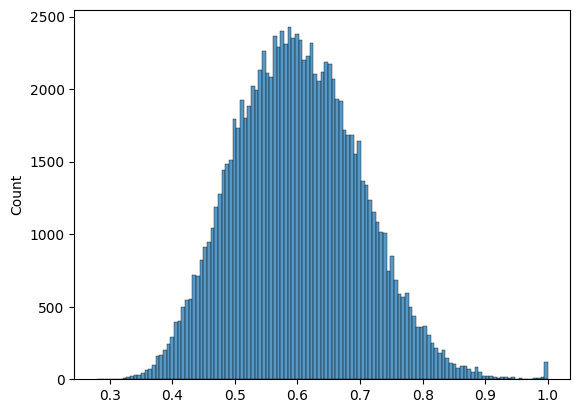

In [60]:
# set vars
trgt_dir = 'data'
agg = ds['agg']

# load metric
bs_metric = evaluate.load('bertscore')
r_metric = evaluate.load('rouge')

# set up output directories
if not os.path.exists(trgt_dir):
    os.mkdir(trgt_dir)
data_path = f'{trgt_dir}/data.json'
if not os.path.isfile(data_path):
    agg.to_json(data_path)


out_ds = {
    'sample_id': [],
    's1': [],
    's2': [],
    's1_src': [],
    's2_src': [],
    's1_sid': [],
    's2_sid': [],
    'simscore': [],
    'l2_dist': [],
    'bertscore': [],
    'r1_score': [],
    'r2_score': [],
}

avg_scores = []
for idx, sample in tqdm(enumerate(agg), total=len(agg), desc=f'{lmda_id+1}/{len(lambda_vals)}'):
    d1_sents = sent_tokenize(sample['d1'])
    d2_sents = sent_tokenize(sample['d2'])
    all_sents = d1_sents + d2_sents
    src_doc = np.array(['d1']*len(d1_sents) + ['d2']*len(d2_sents))
    src_sent_id = np.array(list(range(len(d1_sents))) + list(range(len(d2_sents))))

    embeddings = model.encode(
        all_sents,
        convert_to_tensor=True
    )

    sim_scores = util.cos_sim(embeddings, embeddings).cpu().numpy()

    # get l2 distances
    magnitudes = torch.sum(embeddings**2, dim=-1,keepdim=True)
    distances = torch.sqrt(magnitudes + magnitudes.T - 2*embeddings@embeddings.T).cpu().numpy()

    #X, Y = np.where(sim_scores > 0)
    upper_tri = np.ones_like(sim_scores)
    upper_tri = np.triu(upper_tri)
    np.fill_diagonal(upper_tri, 0)
    X, Y = np.where(upper_tri == 1)

    if len(X) == 0:
        continue

    bertscore = bs_metric.compute(
        predictions=s1,
        references=s2,
        lang='en',
        batch_size=15,
        rescale_with_baseline=True,
    )
    rouge = r_metric.compute(
        predictions=s1,
        references=s2,
        use_aggregator=False,
    )

    s1 = np.array(all_sents)[X]
    s2 = np.array(all_sents)[Y]

    out_ds['sample_id'] += [idx]*len(s1)
    out_ds['s1'] += s1.tolist()
    out_ds['s2'] += s2.tolist()
    out_ds['s1_src'] += src_doc[X].tolist()
    out_ds['s2_src'] += src_doc[Y].tolist()
    out_ds['s1_sid'] += src_sent_id[X].tolist()
    out_ds['s2_sid'] += src_sent_id[Y].tolist()
    out_ds['simscore'] += sim_scores[X, Y].tolist()
    out_ds['l2_dist'] += distances[X, Y].tolist()
    out_ds['bertscore'] += bertscore['f1']
    out_ds['r1_score'] += rouge['rouge1']
    out_ds['r2_score'] += rouge['rouge2']

out_ds = Dataset.from_dict(out_ds)

print(out_ds)
sns.histplot(np.array(out_ds['simscore']))
plt.show()

# Collect Samples From a Specified Threshold and Plot Satistics

Filter:   0%|          | 0/104695 [00:00<?, ? examples/s]

Filter: 100%|██████████| 104695/104695 [00:00<00:00, 153903.22 examples/s]


Dataset({
    features: ['sample_id', 's1', 's2', 's1_src', 's2_src', 's1_sid', 's2_sid', 'simscore', 'l2_dist', 'bertscore', 'r1_score', 'r2_score'],
    num_rows: 136
})


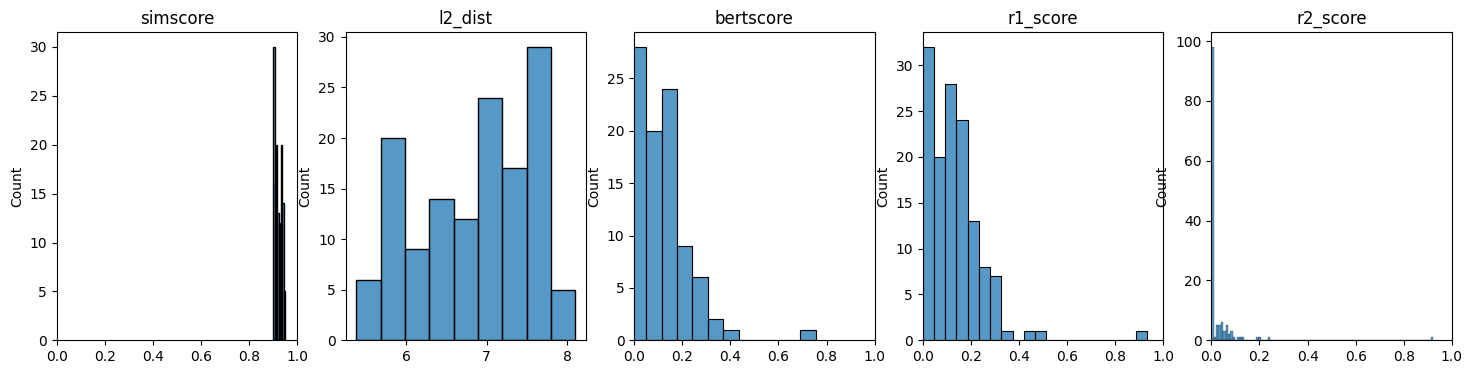

In [63]:
# Set the threshold ranges to inspect
thresh_low  = .9
thresh_high = .95


samples = out_ds.filter(lambda x: x['simscore'] >= thresh_low and x['simscore'] < thresh_high)
print(samples)

scores = ['simscore', 'l2_dist', 'bertscore', 'r1_score', 'r2_score']
fig, ax = plt.subplots(
    1,
    len(scores), 
    #sharey=True, 
    figsize=(18, 4)
)
for i, score in enumerate(scores):
    sns.histplot(samples[score], ax=ax[i])
    ax[i].set_title(score)
    if score != 'l2_dist':
        ax[i].set_xlim([0, 1])

plt.show()


# Inspect Samples

In [73]:
import random
import json
print(json.dumps(samples[random.randint(0, len(samples))], indent=4))

{
    "sample_id": 98,
    "s1": "Supervisors Vote 10-1 To Rename Columbus Day To Indigenous Peoples' Day SAN FRANCISCO (BCN) San Francisco supervisors today voted 10-1 to rename Columbus Day as Indigenous Peoples' Day despite a last-minute effort to delay the vote in response to objections from some members of the city's Italian-American community.",
    "s2": "ANALYSIS/OPINION: San Francisco's Board of Supervisors just voted to rename Columbus Day as Indigenous Peoples day as a means of honoring those people -- those Indians-slash-Native-Americans-slash-Aboriginals-slash-indigenous-slash-what-have-you people -- who lived in this country prior to its European settlement.",
    "s1_src": "d1",
    "s2_src": "d2",
    "s1_sid": 0,
    "s2_sid": 0,
    "simscore": 0.9316031336784363,
    "l2_dist": 6.202868938446045,
    "bertscore": -0.06054043769836426,
    "r1_score": 0.0,
    "r2_score": 0.0
}


In [74]:
print(out_ds)

Dataset({
    features: ['sample_id', 's1', 's2', 's1_src', 's2_src', 's1_sid', 's2_sid', 'simscore', 'l2_dist', 'bertscore', 'r1_score', 'r2_score'],
    num_rows: 104695
})
